<a href="https://colab.research.google.com/github/MIlhamEr/Skripsi/blob/main/GRU%2050%20100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading Dataset

## ADRO

In [2]:
url_adro = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Adaro%20Energy%20Indonesia%20Tbk_2020-2024.csv"
adro = pd.read_csv(url_adro)
adro.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1555.0,1555.0,1490.0,1495.0,835.632202,76612000
1,2020-01-03,1460.0,1470.0,1425.0,1465.0,856.372375,117795600
2,2020-01-06,1455.0,1515.0,1450.0,1465.0,856.372375,61423200
3,2020-01-07,1480.0,1540.0,1460.0,1540.0,900.213867,74336500
4,2020-01-08,1530.0,1535.0,1505.0,1505.0,879.754395,55121100


In [3]:
adro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


## DSSA

In [4]:
url_dssa = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Dian%20Swastatika%20Sentosa%20Tbk_2020-2024.csv"
dssa = pd.read_csv(url_dssa)
dssa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1360.0,1435.0,1360.0,1435.0,1435.0,5000
1,2020-01-03,1435.0,1435.0,1435.0,1435.0,1435.0,0
2,2020-01-06,1437.5,1437.5,1435.0,1435.0,1435.0,3000
3,2020-01-07,1435.0,1435.0,1435.0,1435.0,1435.0,0
4,2020-01-08,1435.0,1435.0,1435.0,1435.0,1435.0,0


In [5]:
dssa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


# Pre-processing Data

## Cleaning Dataset

In [6]:
adro_missing = adro.isnull().sum()
dssa_missing = dssa.isnull().sum()

print("Missing values in ADRO:")
print(adro_missing)
print("\nMissing values in DSSA:")
print(dssa_missing)

Missing values in ADRO:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values in DSSA:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Normalisasi Data

*   Normalisasi data pake MinMaxScaler
*   Kolom Date Ga dipake

In [7]:
scaler = MinMaxScaler()

In [8]:
def normalize_data(df):
    scaled_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:], index=df.index)
    return scaled_df

In [9]:
adro_norm = adro.copy()
adro_norm = normalize_data(adro_norm)
adro_norm = adro_norm.drop('Volume', axis=1)
adro_norm.head()

,Open,High,Low,Close,Adj Close
0,0.260372,0.247207,0.253602,0.243205,0.129805
1,0.233190,0.223464,0.234870,0.234621,0.135675
2,0.231760,0.236034,0.242075,0.234621,0.135675
3,0.238913,0.243017,0.244957,0.256080,0.148084
4,0.253219,0.241620,0.257925,0.246066,0.142293


In [10]:
dssa_norm = dssa.copy()
dssa_norm = normalize_data(dssa_norm)
dssa_norm = dssa_norm.drop('Volume', axis=1)
dssa_norm.head()

,Open,High,Low,Close,Adj Close
0,0.010859,0.011743,0.011073,0.012575,0.012575
1,0.012669,0.011743,0.012918,0.012575,0.012575
2,0.012729,0.011800,0.012918,0.012575,0.012575
3,0.012669,0.011743,0.012918,0.012575,0.012575
4,0.012669,0.011743,0.012918,0.012575,0.012575


## Windowing (Time Series Data)

Model GRU memerlukan data time series, jadi kita perlu membuat window (misalnya 30 hari ke belakang untuk memprediksi harga di hari ke-31).


In [11]:
def prepare_data(df, time_step):
    X, y = [], []
    for i in range(len(df)-time_step):
        t = []
        for j in range(time_step):
            t.append(df.iloc[i + j].values)  # Use all columns for features
        X.append(t)
        y.append(df['High'][i + time_step]) # Predict High price
    return np.array(X), np.array(y)

# Data Mining

# ADRO


In [12]:
time_step = 7
X_adro, y_adro = prepare_data(adro_norm, time_step)

## Target Attribute

Dipilih atribut "high" sebagai target prediksi

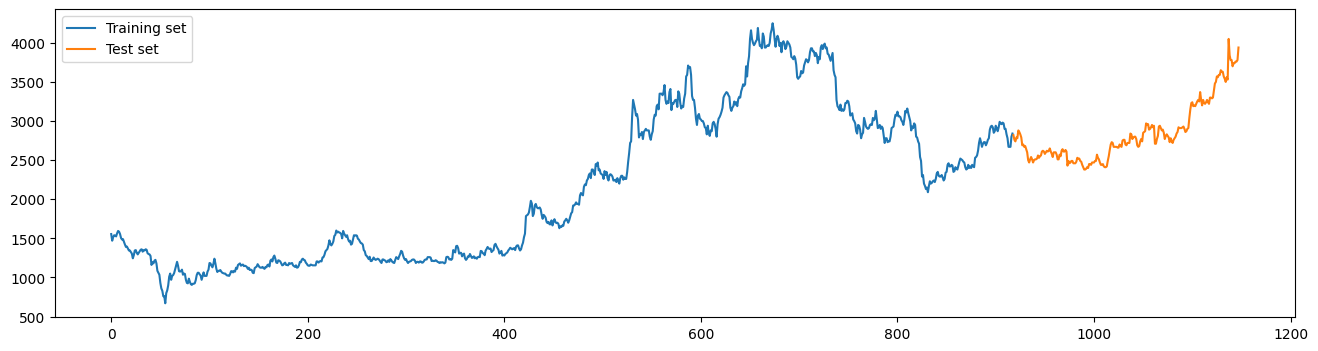

In [13]:
adro["High"][:918].plot(figsize=(16,4),legend=True)
adro["High"][918:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.show()

In [14]:
X_train_adro, X_test_adro, y_train_adro, y_test_adro = train_test_split(X_adro, y_adro, test_size=0.2, random_state=42, shuffle=False)

## Training Model

In [15]:
def create_gru_model(units):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_adro.shape[1], X_train_adro.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) # Output layer with 1 neuron for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [16]:
model_gru_adro = create_gru_model(50)

start_time = time.time()
history = model_gru_adro.fit(X_train_adro, y_train_adro, epochs=100, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0925 - val_loss: 0.0059
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0103 - val_loss: 5.5713e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0044 - val_loss: 8.6144e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 9.8067e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0042 - val_loss: 8.1142e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 7.7698e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 1

## Plot training history

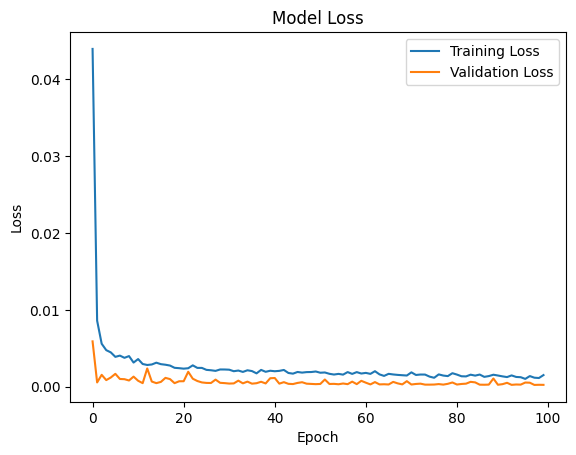

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Prediction

In [18]:
y_pred_adro = model_gru_adro.predict(X_test_adro)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


# DSSA

In [19]:
time_step = 7
X_dssa, y_dssa = prepare_data(dssa_norm, time_step)

## Target Attribute

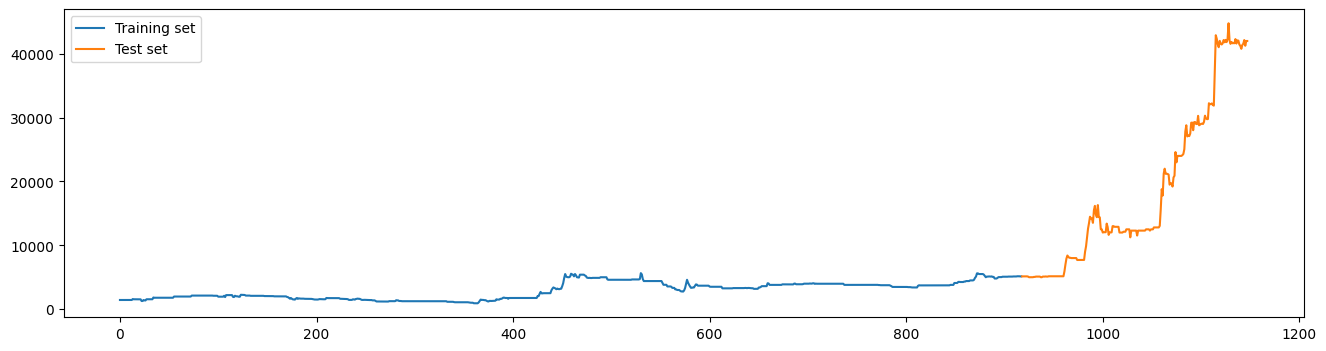

In [20]:
dssa["High"][:918].plot(figsize=(16,4),legend=True)
dssa["High"][918:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.show()

In [21]:
X_train_dssa, X_test_dssa, y_train_dssa, y_test_dssa = train_test_split(X_dssa, y_dssa, test_size=0.2, random_state=42, shuffle=False)

## Training Model

In [22]:
model_gru_dssa = create_gru_model(100)

start_time = time.time()
history = model_gru_dssa.fit(X_train_dssa, y_train_dssa, epochs=100, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 7.1455e-04 - val_loss: 5.2761e-05
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.6637e-05 - val_loss: 1.2609e-05
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.7047e-05 - val_loss: 1.4335e-05
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.5413e-05 - val_loss: 1.1915e-05
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.0695e-05 - val_loss: 1.3875e-05
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.6483e-05 - val_loss: 1.6974e-05
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.8478e-05 - val_loss: 3.3019e-05
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.3225e-05 - val_loss: 1.1106e-05
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.4215e-05 - val_loss: 1.2098e-05
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4345e-05 - val_loss: 1.1934e-05
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.8372e-05

## Plot training history

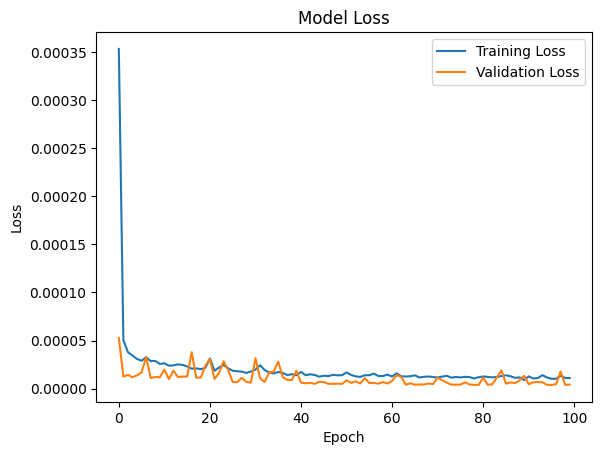

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

##Prediction

In [24]:
y_pred_dssa = model_gru_dssa.predict(X_test_dssa)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


# Evaluasi Model

In [25]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R-squared: {r2:.5f}')

    return rmse, mape, r2

In [26]:
# Evaluate ADRO model
print("Evaluation for ADRO:")
rmse_adro, mape_adro, r2_adro = evaluate_model(y_test_adro, y_pred_adro)

# Evaluate DSSA model
print("\nEvaluation for DSSA:")
rmse_dssa, mape_dssa, r2_dssa = evaluate_model(y_test_dssa, y_pred_dssa)

Evaluation for ADRO:
RMSE: 0.019
MAPE: 17.251%
R-squared: 0.96892

Evaluation for DSSA:
RMSE: 0.025
MAPE: 118.999%
R-squared: 0.99206


# Plot the predicted vs actual values

In [27]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Price', color='orange')
    plt.plot(y_pred, label='Predicted Price', color='green')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

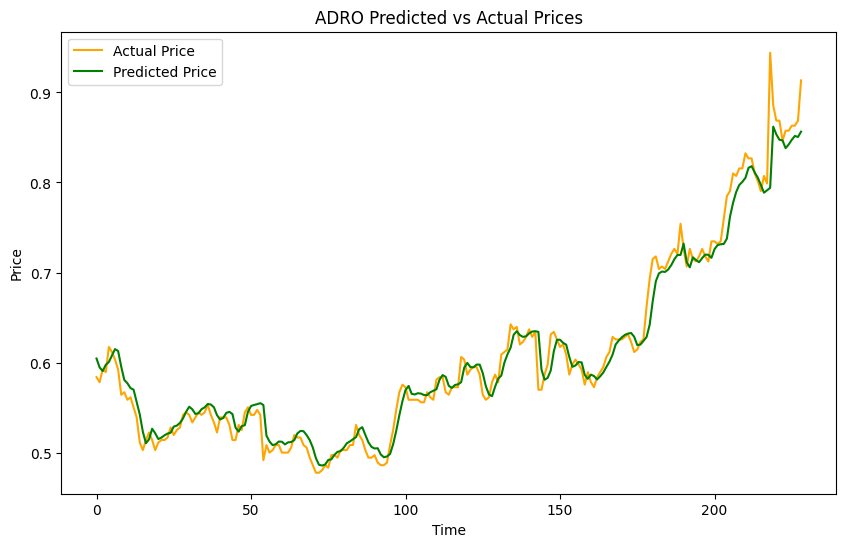

In [28]:
plot_predictions(y_test_adro, y_pred_adro, 'ADRO Predicted vs Actual Prices')

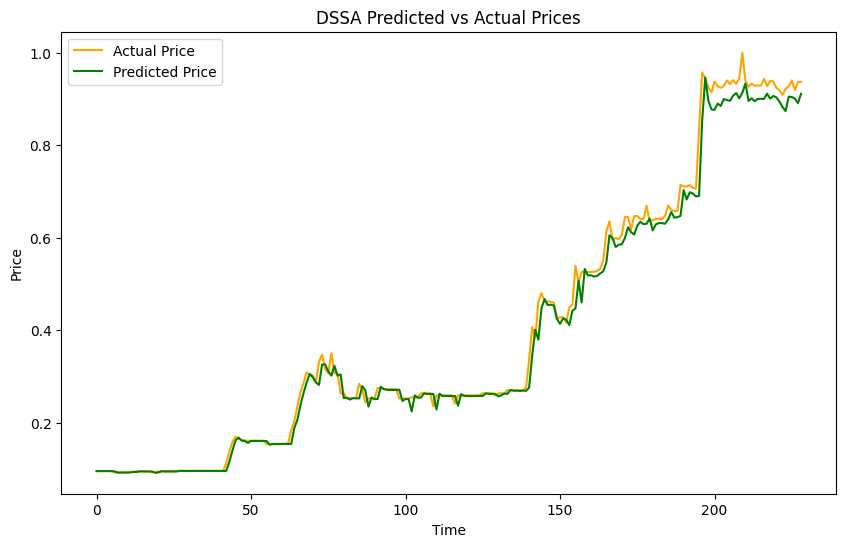

In [29]:
plot_predictions(y_test_dssa, y_pred_dssa, 'DSSA Predicted vs Actual Prices')